In [1]:
import pickle
import numpy as np
from nltk.corpus import stopwords
import nltk
import os
import pandas as pd
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.utils.vis_utils import plot_model

from keras.preprocessing.sequence import pad_sequences
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oagu1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data_file = pd.read_csv('news_data.csv')

Understanding common words

In [67]:
from nltk.corpus import stopwords
Stopwords =  set(stopwords.words('english')) 

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [69]:
def Word_Analysis(Corpus, word_count, N):
  # Vectorizer
  Vectorizer = CountVectorizer(stop_words = Stopwords, ngram_range=(word_count,word_count))

  # word Matrix
  ngrams = Vectorizer.fit_transform(Corpus)

  # word Frequency
  Count = ngrams.sum(axis=0)

  # List of Words
  words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]

  # Sort Descending With Key = Count
  words = sorted(words, key = lambda x:x[1], reverse = True)

  return words[:N]

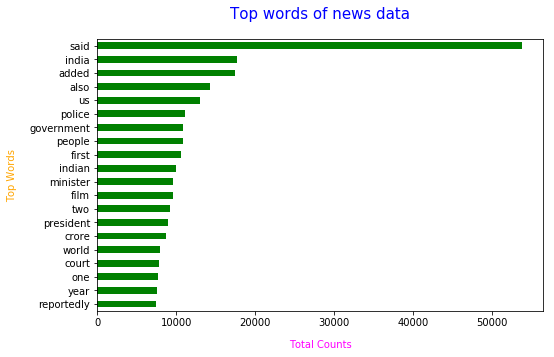

In [70]:
# Finding first word
words = Word_Analysis(data_file['text'], 1, 20)
First_word = pd.DataFrame(words, columns = ["Words", "Counts"])
# Visualization
First_word.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (8, 5))
plt.title("Top words of news data", loc = "center", fontsize = 15, color = "blue", pad = 20)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 12)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "orange", fontsize = 10, labelpad = 12)
plt.show()

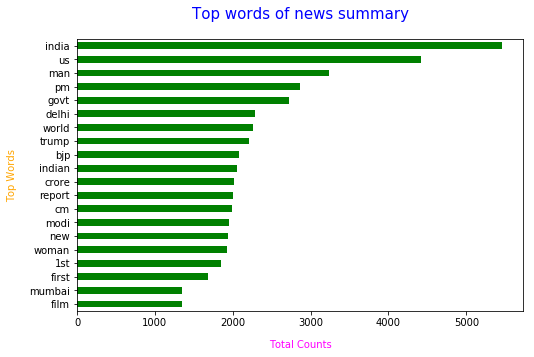

In [72]:
Stopwords.add("sos")
Stopwords.add("eos")
words = Word_Analysis(data_file['headlines'], 1, 20)
First_word = pd.DataFrame(words, columns = ["Words", "Counts"])
# Visualization
First_word.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (8, 5))
plt.title("Top words of news summary", loc = "center", fontsize = 15, color = "blue", pad = 20)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 12)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "orange", fontsize = 10, labelpad = 12)
plt.show()

no surprise there seeing that the majority of the news data was scrapped from publications based in india. 

In [3]:
mxtext = 0
mxsummary = 0
for i in range(len(data_file['text'])):
  mxtext = max(mxtext,len(data_file['text'][i]))
  mxsummary = max(mxsummary,len(data_file['headlines'][i]))

print(mxtext,mxsummary)

frq_text     = []
frq_headline = []

for i in range(len(data_file['text'])):
  frq_text.append(len(data_file['text'][i]))
  frq_headline.append(len(data_file['headlines'][i]))

450 79


Accoridng to the result, the max news lenght is 450 and maximum original summary lenght is 79. Next i want to plot a graph to illustrate this and pick a cut off point.

It's immediately obvious there is a lack of homogeneity in the dataset and some news and summary lenght vary largely in lenght, next we will try to establish a relationship using using the max length for both news and summary on the dataset.

setting maximum news lenght to 400 and summary length to 70 to exclude the outliers.

In [4]:
max_news_len = 400
max_summary_len = 70

I can go further to check the percentage coverage

we also have 100% coverage for the headline/original summary, so we fix max news length to 400 and max summary lenght to 70.

##  Data preprocessing

Next i'm going to do some basic data preprocessing and cleaning, a bit different from my previous experiments.

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
import re

In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [7]:
def clean_text(text,add_eos_sos = False):
    text = text.lower()
    text = re.sub('"','', text)
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])    
    text = re.sub(r"'s\b","",text)
    text = re.sub(r"[-_'()\"#/@;:<>{}`+=~|.!?,]", "", text)
    if add_eos_sos:
      text = '<sos> ' + text + ' <eos>'
    return text

In [8]:
data_file['text'] = data_file['text'].apply(clean_text)


In [9]:
data_file['headlines'] = data_file['headlines'].apply(clean_text,add_eos_sos = True)


Everything is working as expected, we have attached start and stop words to the summary.
since we are using an encoder, decoder architecture, it is important that we define the start and stop words. Terminating the input in an end-of-sequence (EOS) token signals to the encoder that when it receives that input, the output needs to be the finalized embedding. Because of the encoder-decoder structure. The encoder reads the input sequence to construct an embedding representation of the sequence. Terminating the input in an end-of-sequence (EOS) token signals to the encoder that when it receives that input, the output needs to be the finalized embedding. We (normally) don't care about intermediate states of the embedding, and we don't want the encoder to have to guess as to whether or not the input sentence is complete or not.

The EOS token is important for the decoder as well: the explicit "end" token allows the decoder to emit arbitrary-length sequences. The decoder will tell us when it's done emitting tokens: without an "end" token, we would have no idea when the decoder is done talking to us and continuing to emit tokens will produce gibberish.

The start-of-sequence (SOS) token is more important for the decoder: the decoder will progress by taking the tokens it emits as inputs (along with the embedding and hidden state, or using the embedding to initialize the hidden state), so before it has emitted anything it needs a token of some kind to start with. Hence, the SOS token

Next is word tokenizing with keras tf.keras.preprocessing.text.text_to_word_sequence

In [10]:
def text_tokenize(text):
  tokens = []
  for line in text:
    tokens.append(text_to_word_sequence(line, lower=True, split=' '))
  return tokens

In [11]:
news_tokens  = text_tokenize(data_file['text'][:20000])
summary_tokens  = text_tokenize(data_file['headlines'][:20000])

In [12]:
print(data_file['text'][2])



new zealand defeated india by 8 wickets in the fourth odi at hamilton on thursday to win their first match of the fivematch odi series india lost an international match under rohit sharma captaincy after 12 consecutive victories dating back to march 2018 the match witnessed india getting all out for 92 their seventh lowest total in odi cricket history


In [13]:
print(data_file['headlines'][2])


<sos> new zealand end rohit sharmaled india 12match winning streak <eos>


## Word Embedding

First we set a vocabularly size

In [14]:
VOCABUlARLY = 7000

using keras fit_on_texts that updates internal vocabulary based on a list of texts and word_index to basically change from token to actual word.

In [15]:
def textVocabularly(texts, vocab):
  tokenizer = Tokenizer(num_words=vocab)
  tokenizer.fit_on_texts(texts)
  dictionary = tokenizer.word_index
  word2idx = {}
  idx2word = {}
  for k, v in dictionary.items():
      if v < vocab:
          word2idx[k] = v-1
          idx2word[v-1] = k
      if v >= vocab:
          break
  return word2idx, idx2word

In [16]:
word2idx, idx2word = textVocabularly(data_file['text']+data_file['headlines'],VOCABUlARLY)
word_index = {}
word_index['word2idx'] = word2idx
word_index['idx2word'] = idx2word

as abserved, each word now has a corresponding integer token that represents that index word. 

In [17]:
idx2word = word_index['idx2word']
word2idx = word_index['word2idx']


Adding glove embedding from http://nlp.stanford.edu/data/glove.42B.300d.zip

In [18]:
GLOVE_LENGHT = 300
GLOVE_DATA = 'glove.42B.300d.txt'

def readGlove(glovepath, lenght):
    embeddings = {}
    with open(glovepath,encoding="utf8") as glove_f:
        for line in glove_f:
            chunks = line.split()
            assert len(chunks) == lenght + 1
            embeddings[chunks[0]] = np.array(chunks[1:], dtype='float32')
    return embeddings


In [19]:
GLOVE_INDEX = readGlove(GLOVE_DATA, GLOVE_LENGHT)

In [20]:
def embedding_matrix_creater(word_index,embedding_dimention = 300):
  embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimention))
  for i, word in word_index.items():
      embedding_vector = GLOVE_INDEX.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  return embedding_matrix
  


In [21]:
embedding_matrix = embedding_matrix_creater(idx2word)

In [22]:

def token2seq(text):
  seq = []
  for line in text:
    temp = []
    for word in line:
      if word in word2idx.keys():
        temp.append(word2idx[word])
    seq.append(temp)
  return seq



In [23]:
news_seq = token2seq(news_tokens)
summary_seq = token2seq(summary_tokens)

In [24]:
# padding
news_seq = pad_sequences(news_seq, maxlen = max_news_len, dtype='int32', padding='post', truncating='post')
summary_seq = pad_sequences(summary_seq, maxlen = max_summary_len, dtype='int32', padding='post', truncating='post')

The tokens are in sequence now, time to build the model

# Model Building

In [25]:
import re           
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional,LSTM,Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from attention import AttentionLayer


In [26]:
from keras import backend as K 
K.clear_session() 

EMBEDDING_DIM = 300

# Encoder 
encoder_inputs = Input(shape=(max_news_len,))  ### input (none,max_input_len)

## embedding
enc_emb_layer = Embedding(input_dim = VOCABUlARLY, output_dim = EMBEDDING_DIM, 
                      input_length = max_news_len, weights = [embedding_matrix],trainable = False)

enc_emb = enc_emb_layer(encoder_inputs)




#LSTM 1 
encoder_lstm1 = Bidirectional(LSTM(EMBEDDING_DIM,return_sequences=True,return_state=True))
encoder_output1, _,_,_,_ = encoder_lstm1(enc_emb) 


#LSTM 2 
encoder_lstm2 =   Bidirectional(LSTM(EMBEDDING_DIM, return_state=True, return_sequences=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm2(encoder_output1) 
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
#encoder_states = [state_h, state_c]



# Set up the decoder. 
decoder_inputs = Input(shape=(None,))  ## input(None,)

### embedding

dec_emb_layer = Embedding(input_dim = VOCABUlARLY, output_dim = EMBEDDING_DIM, 
                      input_length = max_summary_len, weights = [embedding_matrix],trainable = False)


dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(EMBEDDING_DIM*2, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(VOCABUlARLY, activation='softmax'))
decoder_dense_outputs = decoder_dense(decoder_concat_input) 





model = Model(inputs = [encoder_inputs, decoder_inputs], outputs = decoder_dense_outputs)

In [27]:
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy') 
model.load_weights('main_weights.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 300)     2100000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 400, 600), ( 1442400     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [28]:
#from tensorflow.keras.utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [29]:
#Adding Callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [30]:
history = {}
history['loss'] = []
history['val_loss'] = []
epochs = 1
#val_loss_prev = history['val_loss'][-1]
for i in range(epochs):
  #train model
  epoch_history = model.fit([news_seq,summary_seq[:,:-1]], summary_seq.reshape(summary_seq.shape[0],summary_seq.shape[1], 1)[:,1:] ,
                      epochs=1,batch_size=100,validation_split = 0.05)
  
  ### save model weight on every epochs
  model.save_weights('test_weight.h5')   

  
  

  history['loss'].append(epoch_history.history['loss'])
  history['val_loss'].append(epoch_history.history['val_loss'])
  model.save('model.h5') 
  pickle.dump(history,open('history2.pkl','wb')) 

190/190 [==============================] - 25528s 134s/step - loss: 0.5325 - val_loss: 0.5197


In [31]:
import matplotlib.pyplot as plt
plt.plot(history['loss'], label='train') 
plt.plot(history['val_loss'], label='test') 
plt.legend()
plt.show()


<Figure size 640x480 with 1 Axes>

Decoding

In [32]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])




# decoder inference


decoder_state_input_h = Input(shape=(600,))
decoder_state_input_c = Input(shape=(600,))
decoder_hidden_state_input = Input(shape=(max_news_len,600))


dec_emb2= dec_emb_layer(decoder_inputs)


decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])


decoder_outputs2 = decoder_dense(decoder_inf_concat)




# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],[decoder_outputs2] + [state_h2, state_c2])

In [33]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = word2idx['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = idx2word[sampled_token_index]

        if(sampled_token!='sos'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'eos' or len(decoded_sentence.split()) >= (max_news_len-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [34]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=word2idx['sos']) and i!=word2idx['eos']):
        newString=newString+idx2word[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+idx2word[i]+' '
    return newString

In [35]:
for i in range(0,15):
  print("Text : ",seq2text(news_seq[i]))
  print("Original summary :",seq2summary(summary_seq[i]))
  print("Predicted summary :",decode_sequence(news_seq[i].reshape(1,max_news_len)),'\n\n')

Text :  an of and program in machine learning and artificial intelligence was a systems engineer at infosys with almost 5 years of work experience program and career support helped him transition to a data scientist at tech mahindra with 90 salary hike online power learning has powered 3 lakh 
Original summary : to career in al with 90 salary hike 
Predicted summary :  iit iit to be in tech company eos 


Text :  kunal shah credit card bill payment platform gave users a chance to win free food from swiggy for one year a delhi bagged this reward after spending 2000 coins users get one coin per rupee of bill paid which can be used to avail from brands like and more 
Original summary : delhi wins free food from swiggy for one year on 
Predicted summary :  big b to win from a year for not a year eos 


Text :  new zealand defeated india by 8 wickets in fourth odi at hamilton on thursday to win their first match of odi series india lost an international match under rohit sharma captaincy af

trying new prediction

In [36]:
#BLEU Score of Training set
#n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu

In [37]:
for i in range(0,1000):
  reference = seq2summary(summary_seq[i])
  candidate = decode_sequence(news_seq[i].reshape(1, max_news_len))

print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

Individual 1-gram: 0.407407
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000


C:\Users\oagu1\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\oagu1\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\oagu1\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnin

In [42]:
from nltk.translate.bleu_score import SmoothingFunction
chencherry = SmoothingFunction()

In [43]:
for i in range(0,1000):
  reference = seq2summary(summary_seq[i])
  candidate = decode_sequence(news_seq[i].reshape(1, max_news_len))

print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0),smoothing_function=chencherry.method1))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method1))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0),smoothing_function=chencherry.method1))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=chencherry.method1))

Cumulative 1-gram: 0.407407
Cumulative 2-gram: 0.039585
Cumulative 3-gram: 0.019189
Cumulative 4-gram: 0.012712


In [44]:
for i in range(0,1000):
  reference = seq2summary(summary_seq[i])
  candidate = decode_sequence(news_seq[i].reshape(1, max_news_len))

print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0),smoothing_function=chencherry.method2))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method2))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0),smoothing_function=chencherry.method2))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=chencherry.method2))

Cumulative 1-gram: 0.428571
Cumulative 2-gram: 0.125988
Cumulative 3-gram: 0.086951
Cumulative 4-gram: 0.070297


In [45]:
for i in range(0,1000):
  reference = seq2summary(summary_seq[i])
  candidate = decode_sequence(news_seq[i].reshape(1, max_news_len))

print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0),smoothing_function=chencherry.method3))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method3))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0),smoothing_function=chencherry.method3))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=chencherry.method3))

Cumulative 1-gram: 0.407407
Cumulative 2-gram: 0.088514
Cumulative 3-gram: 0.044160
Cumulative 4-gram: 0.025274


In [47]:
from rouge import Rouge

In [ ]:
checking rouge score

In [52]:
rouge = Rouge()
for i in range(0,1000):
  reference = seq2summary(summary_seq[i])
  summary = decode_sequence(news_seq[i].reshape(1, max_news_len))
scores = rouge.get_scores(summary,reference, ignore_empty=True)
print(scores)

TypeError: get_scores() got an unexpected keyword argument 'ignore_empty'

In [63]:
for i in range(0,1000):
  reference = seq2summary(summary_seq[i])
  candidate = decode_sequence(news_seq[i].reshape(1, max_news_len))

print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0),smoothing_function=chencherry.method4))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method4))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0),smoothing_function=chencherry.method4))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=chencherry.method4))

Cumulative 1-gram: 0.407407
Cumulative 2-gram: 0.402316
Cumulative 3-gram: 0.362055
Cumulative 4-gram: 0.317705


In [64]:
for i in range(0,1000):
  reference = seq2summary(summary_seq[i])
  candidate = decode_sequence(news_seq[i].reshape(1, max_news_len))

print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0),smoothing_function=chencherry.method5))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method5))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0),smoothing_function=chencherry.method5))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=chencherry.method5))

Cumulative 1-gram: 0.604938
Cumulative 2-gram: 0.349261
Cumulative 3-gram: 0.204901
Cumulative 4-gram: 0.116420


In [66]:
for i in range(0,1000):
  reference = seq2summary(summary_seq[i])
  candidate = decode_sequence(news_seq[i].reshape(1, max_news_len))

print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0),smoothing_function=chencherry.method7))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method7))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0),smoothing_function=chencherry.method7))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=chencherry.method7))

Cumulative 1-gram: 0.737368
Cumulative 2-gram: 0.590568
Cumulative 3-gram: 0.488094
Cumulative 4-gram: 0.379627


In [55]:
reference = """congress candidate won assembly seat in rajasthan by defeating bjp singh with
a margin of votes in bypoll with this victory congress has taken its total to 
100 seats in assembly election to seat was delayed due to death of sitting mla and bsp candidate laxman singh """
summary = """congress wins rajasthan assembly in rajasthan """
rouge = Rouge()
scores = rouge.get_scores(summary,reference)
print(scores)

{}


In [61]:
from rouge import Rouge 

hypothesis = "the #### transcript is a written version of each day 's cnn student news program use this transcript to he    lp students with reading comprehension and vocabulary use the weekly newsquiz to test your knowledge of storie s you     saw on cnn student news"

reference = "this page includes the show transcript use the transcript to help students with reading comprehension and     vocabulary at the bottom of the page , comment for a chance to be mentioned on cnn student news . you must be a teac    her or a student age # # or older to request a mention on the cnn student news roll call . the weekly newsquiz tests     students ' knowledge of even ts in the news"

rouge = Rouge()
thescores = rouge.get_scores(hypothesis, reference)

In [62]:
print(thescores)

{}
